In [1]:
from google.colab import files
uploaded = files.upload()

Saving CreditCard_Fraud_Detection.csv to CreditCard_Fraud_Detection.csv


Dataset 'CreditCard_Fraud_Detection.csv' loaded successfully.

--- 1. Dataset Description ---

First 5 rows of the dataset:
  Transaction ID Cardholder ID  Transaction Amount Merchant Type     Location  \
0      TID000001         CH001             1878.96        Travel      Houston   
1      TID000002         CH002             4754.06        Travel  Los Angeles   
2      TID000003         CH003             3662.65   Electronics  Los Angeles   
3      TID000004         CH004             2997.31       Grocery  Los Angeles   
4      TID000005         CH005              788.53       Grocery      Chicago   

   Time of Transaction  Is Fraud  
0  2025-01-01 00:00:00         0  
1  2025-01-01 01:00:00         0  
2  2025-01-01 02:00:00         0  
3  2025-01-01 03:00:00         0  
4  2025-01-01 04:00:00         0  

Dataset shape:
(1000, 7)

Dataset information (data types and non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 col

<ipython-input-2-e9035bfa73d9>:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_column, data=df, palette='viridis')


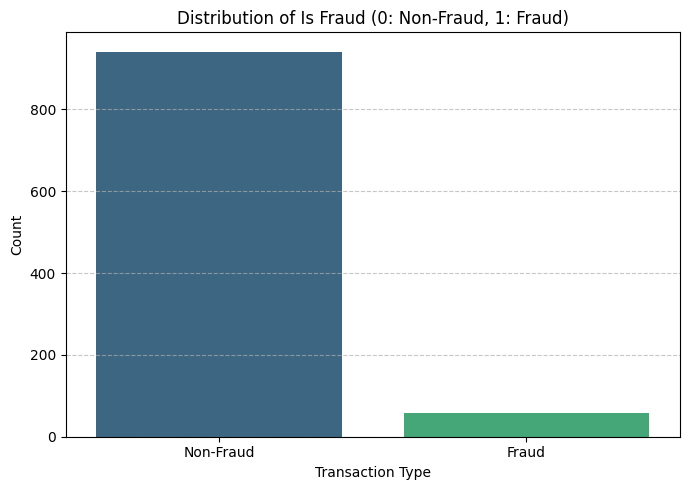

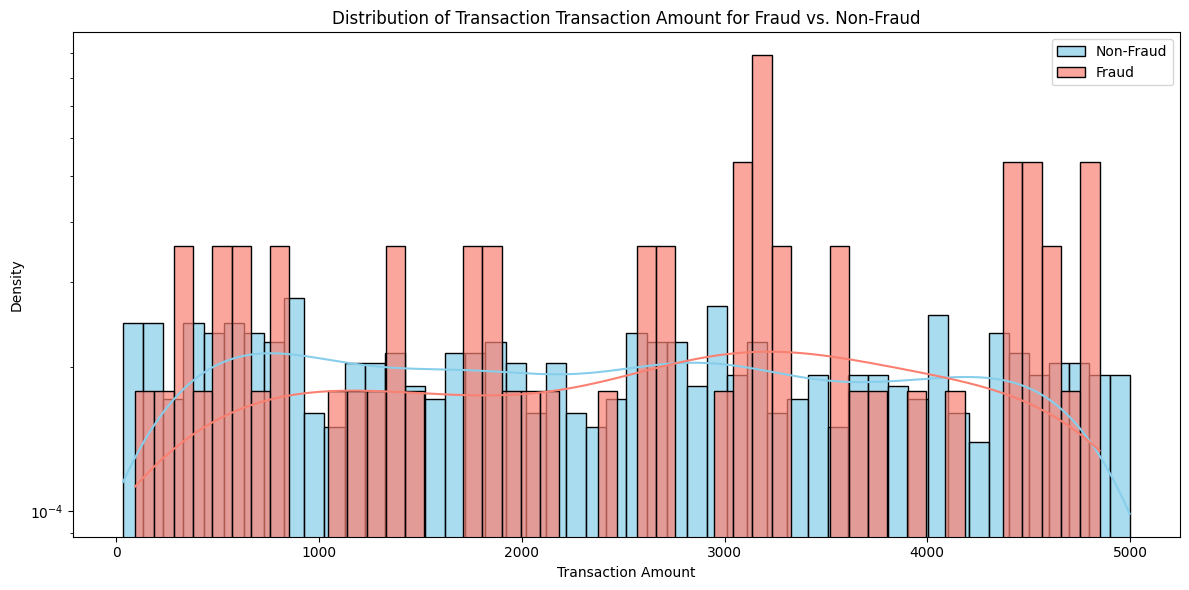

<ipython-input-2-e9035bfa73d9>:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_column, y=feature, data=df, palette='coolwarm')


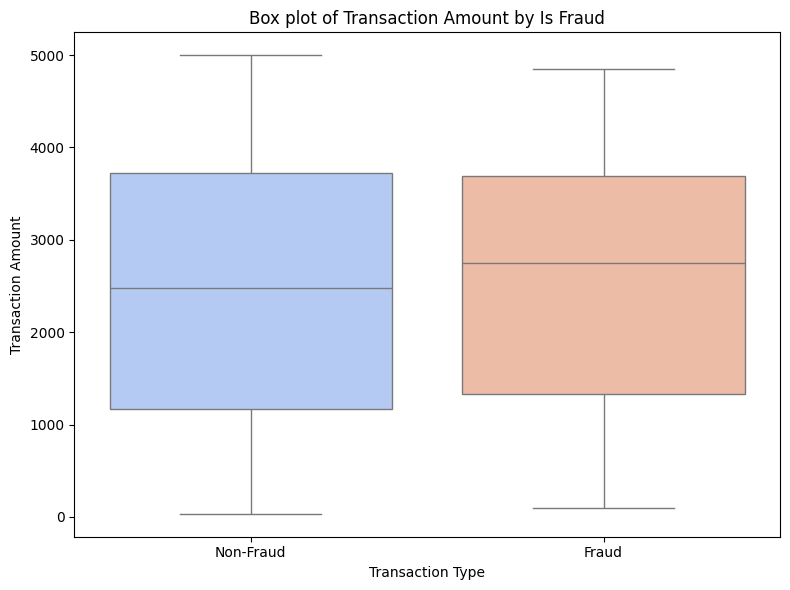

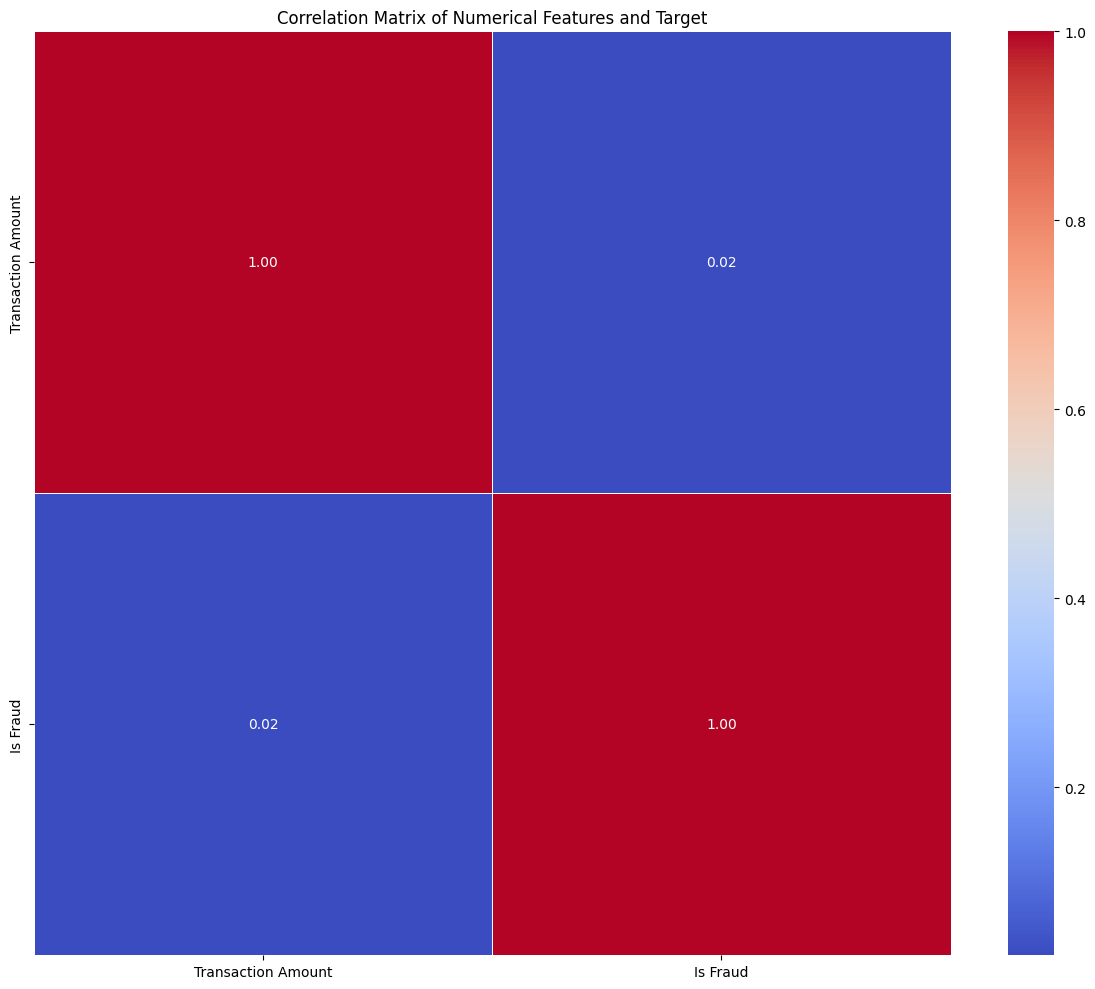


Exploratory Data Analysis (EDA) complete.


--- 4. Feature Engineering ---
Creating interaction features (e.g., Transaction Amount * V-features)...
Creating polynomial features (e.g., Transaction Amount^2)...
 - Created 'Transaction Amount^2'

Updated Numerical Features for Scaling: ['Transaction Amount', 'Transaction Amount^2']
Updated Categorical Features for One-Hot Encoding: ['Transaction ID', 'Cardholder ID', 'Merchant Type', 'Location', 'Time of Transaction']

Feature Engineering complete and data re-processed.


--- 5. Model Building ---
Using Gaussian Naive Bayes Classifier.
Training the model...
Model training complete.

--- 6. Model Evaluation ---

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79       188
           1       0.08      0.42      0.13        12

    accuracy                           0.66       200
   macro avg       0.51      0.55      0.46       200
weighted avg       0.90      0.66    

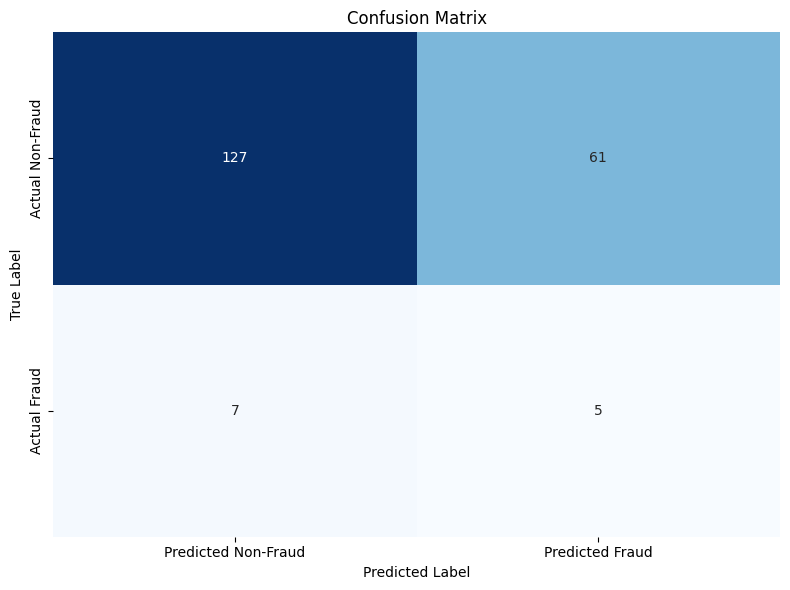

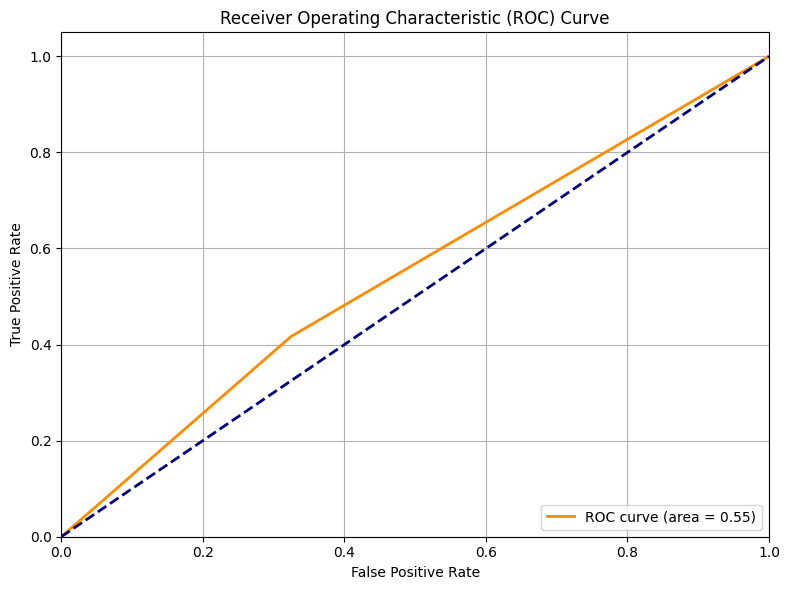


Area Under ROC Curve (AUC): 0.5461

Model Evaluation complete.

--- 7. Visualization of Results & Model Insights ---


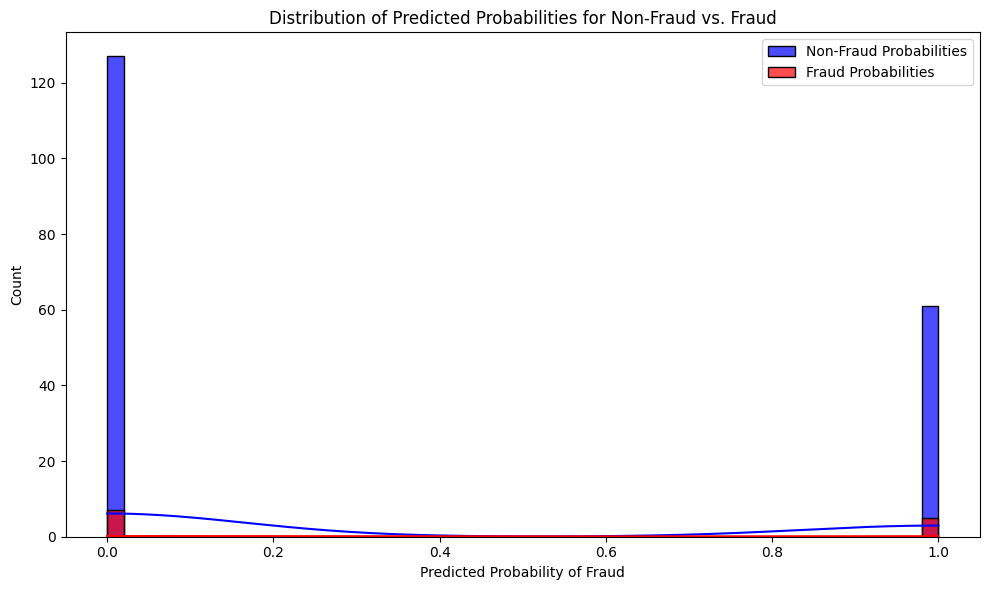


Visualization of Results & Model Insights complete.


Project Workflow Complete!


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
file_path = "CreditCard_Fraud_Detection.csv"
try:
    df = pd.read_csv(file_path)
    print(f"Dataset '{file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure it's in the correct directory.")
    exit() # Exit if the file isn't found

# Define the target column - assuming 'Is Fraud' based on typical datasets
target_column = 'Is Fraud'
# Define the correct column name for the transaction amount
amount_column = 'Transaction Amount' # Corrected column name

# --- 1. Dataset Description ---
print("\n" + "="*50)
print("--- 1. Dataset Description ---")
print("="*50)

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset shape:")
print(df.shape)

print("\nDataset information (data types and non-null counts):")
df.info()

print("\nColumn names:")
print(df.columns.tolist())

print("\nDescriptive statistics for numerical features:")
print(df.describe())

if target_column in df.columns:
    print(f"\nDistribution of the target variable ('{target_column}'):")
    print(df[target_column].value_counts())
    print(f"\nNormalized distribution of the target variable ('{target_column}'):")
    print(df[target_column].value_counts(normalize=True))
    # Check for class imbalance
    fraud_percentage = df[target_column].value_counts(normalize=True).get(1, 0) * 100
    if fraud_percentage < 5: # Threshold for considering highly imbalanced
        print(f"\nDetected significant class imbalance: Only {fraud_percentage:.2f}% of transactions are fraudulent.")
        print("This will need careful handling during modeling (e.g., SMOTE, class weights, appropriate metrics).")
else:
    print(f"\nWarning: The expected target column '{target_column}' was not found.")
    print("Please inspect the column names above and identify the correct target variable for fraud.")
    # As a fallback, show distribution of the last column if target is not found
    if len(df.columns) > 0:
        potential_target = df.columns[-1]
        print(f"\nAttempting to show distribution for the last column ('{potential_target}') as a potential target:")
        try:
            print(df[potential_target].value_counts())
            print(df[potential_target].value_counts(normalize=True))
        except Exception as e:
            print(f"Could not display distribution for column '{potential_target}': {e}")
    # If target not found, we cannot proceed with supervised learning
    exit("Cannot proceed without a clearly defined target variable.")

print("\nMissing values per column:")
print(df.isnull().sum())
if df.isnull().sum().sum() == 0:
    print("No missing values found in the dataset.")
else:
    print("Missing values detected. Imputation/handling will be part of preprocessing.")


print("\nDataset Description complete.\n")

# --- 2. Data Preprocessing ---
print("\n" + "="*50)
print("--- 2. Data Preprocessing ---")
print("="*50)

# Identify numerical and categorical features (excluding the target and potentially 'Time' or 'ID' if present and not directly useful)
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if target_column in numerical_features:
    numerical_features.remove(target_column)

# Assuming 'Time' might be a feature that needs special handling or removal if it's just a sequence
if 'Time' in numerical_features:
    print("Removing 'Time' column from numerical features for standard scaling, consider feature engineering from it.")
    numerical_features.remove('Time')
    # You might want to create features from 'Time' before removing it, e.g., 'hour_of_day', 'day_of_week'

# For simplicity, we'll keep all numerical features except the target for scaling.
# If 'Time' was meant to be used for sequential data, a different approach would be needed.

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("\nIdentified Numerical Features for Scaling:", numerical_features)
print("Identified Categorical Features for One-Hot Encoding:", categorical_features)

# Split data into features (X) and target (y)
X = df.drop(target_column, axis=1)
y = df[target_column]

# Split data into training and testing sets (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nOriginal X_train shape: {X_train.shape}")
print(f"Original X_test shape: {X_test.shape}")
print(f"Original y_train distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Original y_test distribution:\n{y_test.value_counts(normalize=True)}")

print("\nData Preprocessing complete (initial split).\n")

# --- 3. Exploratory Data Analysis (EDA) ---
print("\n" + "="*50)
print("--- 3. Exploratory Data Analysis (EDA) ---")
print("="*50)

# 3.1. Target Variable Distribution (already done in Dataset Description, but good to re-emphasize)
plt.figure(figsize=(7, 5))
sns.countplot(x=target_column, data=df, palette='viridis')
plt.title(f'Distribution of {target_column} (0: Non-Fraud, 1: Fraud)')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.2. Distribution of Amount for Fraud vs. Non-Fraud
plt.figure(figsize=(12, 6))
# Corrected 'Amount' to 'Transaction Amount'
sns.histplot(df[df[target_column] == 0][amount_column], bins=50, color='skyblue', label='Non-Fraud', kde=True, stat='density', alpha=0.7)
sns.histplot(df[df[target_column] == 1][amount_column], bins=50, color='salmon', label='Fraud', kde=True, stat='density', alpha=0.7)
plt.title(f'Distribution of Transaction {amount_column} for Fraud vs. Non-Fraud') # Corrected title
plt.xlabel(amount_column) # Corrected xlabel
plt.ylabel('Density')
plt.yscale('log') # Use log scale for y-axis due to potential large differences
plt.legend()
plt.tight_layout()
plt.show()

# 3.3. Distribution of Time (if 'Time' column exists and is numeric)
if 'Time' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(df[df[target_column] == 0]['Time'], bins=50, color='lightgreen', label='Non-Fraud', kde=True, stat='density', alpha=0.7)
    sns.histplot(df[df[target_column] == 1]['Time'], bins=50, color='red', label='Fraud', kde=True, stat='density', alpha=0.7)
    plt.title('Distribution of Transaction Time for Fraud vs. Non-Fraud')
    plt.xlabel('Time (seconds since first transaction)')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 3.4. Box plots for selected numerical features (e.g., Amount) against target
# Corrected 'Amount' to 'Transaction Amount'
for feature in [amount_column] + (['Time'] if 'Time' in df.columns else []):
    if feature in df.columns: # Added check if the feature exists in the DataFrame
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=target_column, y=feature, data=df, palette='coolwarm')
        plt.title(f'Box plot of {feature} by {target_column}')
        plt.xlabel('Transaction Type')
        plt.ylabel(feature)
        plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: Column '{feature}' not found for box plot.")


# 3.5. Correlation Matrix for numerical features (if many numerical features)
# Select numerical features that are not 'Time' or 'Amount' (as they were already analyzed)
# and include the target for correlation with fraud.
# Corrected 'Amount' to 'Transaction Amount' in the list comprehension
eda_numerical_cols = [col for col in numerical_features if col not in ['Time', amount_column]] + [amount_column] + [target_column]
if 'Time' in df.columns:
    eda_numerical_cols.append('Time')

# Ensure columns exist before calculating correlation
eda_numerical_cols = [col for col in eda_numerical_cols if col in df.columns]

if len(eda_numerical_cols) > 1: # Need at least 2 columns for correlation
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[eda_numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=".5")
    plt.title('Correlation Matrix of Numerical Features and Target')
    plt.tight_layout()
    plt.show()
else:
    print(f"\nNot enough numerical features to display a meaningful correlation matrix beyond '{amount_column}' and 'Time'.")


print("\nExploratory Data Analysis (EDA) complete.\n")

# --- 4. Feature Engineering ---
print("\n" + "="*50)
print("--- 4. Feature Engineering ---")
print("="*50)

# Create a copy to avoid modifying the original split data directly
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

# Example Feature Engineering ideas:

# 4.1. Time-based features (if 'Time' column exists)
if 'Time' in X_train_fe.columns:
    print("Creating time-based features...")
    # Assuming 'Time' is in seconds, convert to hours and day
    X_train_fe['Hour'] = X_train_fe['Time'].apply(lambda x: np.floor(x / 3600) % 24)
    X_test_fe['Hour'] = X_test_fe['Time'].apply(lambda x: np.floor(x / 3600) % 24)
    # You could also add 'Day' (e.g., total_days = Time / (3600*24)) if your 'Time' spans multiple days.

# 4.2. Interaction features (e.g., Amount * V1, Amount * V2 etc.)
# Select a few 'V' features to create interactions with 'Amount'
print(f"Creating interaction features (e.g., {amount_column} * V-features)...") # Corrected print statement
v_cols_for_interaction = ['V1', 'V2', 'V3', 'V4', 'V5'] # Example V-features
for v_col in v_cols_for_interaction:
    # Corrected 'Amount' to 'Transaction Amount' in the column check and creation
    if v_col in X_train_fe.columns and amount_column in X_train_fe.columns:
        X_train_fe[f'{amount_column}x{v_col}'] = X_train_fe[amount_column] * X_train_fe[v_col]
        X_test_fe[f'{amount_column}x{v_col}'] = X_test_fe[amount_column] * X_test_fe[v_col]
        print(f" - Created '{amount_column}x{v_col}'")

# 4.3. Polynomial features (e.g., Amount^2)
# Using a simple PolynomialFeatures for 'Amount'
print(f"Creating polynomial features (e.g., {amount_column}^2)...") # Corrected print statement
poly = PolynomialFeatures(degree=2, include_bias=False)
# Corrected 'Amount' to 'Transaction Amount'
if amount_column in X_train_fe.columns:
    amount_poly_train = poly.fit_transform(X_train_fe[[amount_column]])
    amount_poly_test = poly.transform(X_test_fe[[amount_column]])
    # Rename columns and add to dataframe
    # Corrected 'Amount' to 'Transaction Amount' in get_feature_names_out
    poly_feature_names = poly.get_feature_names_out([amount_column])
    for i, name in enumerate(poly_feature_names):
        if name != amount_column: # Don't re-add the original 'Amount'
            X_train_fe[name] = amount_poly_train[:, i]
            X_test_fe[name] = amount_poly_test[:, i]
            print(f" - Created '{name}'")

# Update numerical and categorical features lists based on newly created features
numerical_features_fe = X_train_fe.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_fe = X_train_fe.select_dtypes(include=['object']).columns.tolist()

print("\nUpdated Numerical Features for Scaling:", numerical_features_fe)
print("Updated Categorical Features for One-Hot Encoding:", categorical_features_fe)

# Define the preprocessor again with updated feature lists
# Important: Ensure the original 'Time' column is handled correctly if it was dropped earlier.
# For this example, if 'Time' was numerical and was removed, it should not be in numerical_features_fe
# unless explicitly added back as a feature for scaling.

preprocessor_fe = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_fe),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_fe)
    ],
    remainder='passthrough' # Keep any other columns if they exist and are not transformed
)

# Apply preprocessing to training and testing data
X_train_processed = preprocessor_fe.fit_transform(X_train_fe)
X_test_processed = preprocessor_fe.transform(X_test_fe)

print("\nFeature Engineering complete and data re-processed.\n")

# --- 5. Model Building ---
print("\n" + "="*50)
print("--- 5. Model Building ---")
print("="*50)

# Using Gaussian Naive Bayes as a simple baseline model
model = GaussianNB()
print("Using Gaussian Naive Bayes Classifier.")

# Train the model
print("Training the model...")
# Convert sparse matrices to dense NumPy arrays before fitting
model.fit(X_train_processed.toarray(), y_train)
print("Model training complete.")

# --- 6. Model Evaluation ---
print("\n" + "="*50)
print("--- 6. Model Evaluation ---")
print("="*50)

# Make predictions on the test set
# Also convert the test set sparse matrix to a dense NumPy array for prediction
y_pred = model.predict(X_test_processed.toarray())
y_prob = model.predict_proba(X_test_processed.toarray())[:, 1] # Probabilities for the positive class (fraud)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nArea Under ROC Curve (AUC): {roc_auc:.4f}")
print("\nModel Evaluation complete.")

# --- 7. Visualization of Result & Model Insights (Additional) ---
print("\n" + "="*50)
print("--- 7. Visualization of Results & Model Insights ---")
print("="*50)

# For Naive Bayes, direct feature importance isn't as straightforward as tree models.
# However, we can look at the distributions of features that the model found important.
# For more complex models (e.g., RandomForest, XGBoost), you would plot feature_importances_.

# Example: Analyze the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(y_prob[y_test == 0], bins=50, color='blue', label='Non-Fraud Probabilities', kde=True, alpha=0.7)
sns.histplot(y_prob[y_test == 1], bins=50, color='red', label='Fraud Probabilities', kde=True, alpha=0.7)
plt.title('Distribution of Predicted Probabilities for Non-Fraud vs. Fraud')
plt.xlabel('Predicted Probability of Fraud')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Further insights for Naive Bayes often involve looking at the means and variances of features
# for each class. (This is more complex to visualize generally without a specific model output.)

print("\nVisualization of Results & Model Insights complete.\n")

print("\n" + "="*50)
print("Project Workflow Complete!")
print("="*50)